# 从全连接层到卷积
:label:`sec_why-conv`

我们之前讨论的多层感知机十分适合处理表格数据。表格数据中的每行对应每个样本，每列分别对应每个特征。这些特征之间的交互可能产生影响，但我们没有考虑特征交互结构上的先验假设。

有时我们缺乏足够的知识来指导更巧妙的模型结构设计，此时多层感知机可能是最好的选择。然而，对于高维感知数据，这种无结构网络可能会变得笨拙。

例如，在之前区分猫和狗的例子中。假设我们收集了一个照片数据集，每张照片具有百万级像素，这意味着多层感知机的每次输入都有一百万个维度。
根据我们在 :numref:`subsec_parameterization-cost-fc-layers` 中对全连接层参数开销的讨论。即使将隐藏层维度降低到 $1000$ ，这个神经网络也将有 $10^6 \times 10^3 = 10^9$ 个参数。想要训练这个模型很难，需要有大量的GPU、分布式优化训练的经验和超乎常人的耐心。


细心的读者可能会反对这一论点，认为要求百万像素的分辨率可能不是必要的。
然而，即使减小为十万像素，$1000$ 个隐藏单元的隐藏层也可能不足以学习到良好的图像特征，所以我们仍然需要数十亿个参数。
此外，拟合如此多的参数还需要收集大量的数据。
然而，如今人类视觉和传统机器学习模型都能很好地区分猫和狗。这是因为图像中有丰富的结构，人类和机器学习模型都可以利用这些结构。
*卷积神经网络*（convolutional neural networks，CNN）是机器学习利用自然图像中一些已知结构的创造性方法。


## 不变性

想象一下，你想对一张图片中的物体进行检测。合理的做法是，我们使用的无论哪种方法都应该和物体的位置无关。
虽然猪通常不在天上飞，飞机通常不在水里游泳，我们仍然应该意识到猪有可能出现在图片的上方。
我们可以从儿童游戏 ”沃尔多在哪里”（ :numref:`img_waldo` ）中汲取一些灵感。
这个游戏包含许多混乱的场景，游戏玩家的目标是找到沃尔多，而沃尔多通常潜伏在一些不太可能的位置。
所以尽管沃尔多的样子很有特点，在眼花缭乱的场景中找到他也如大海捞针。

然而沃尔多的样子并不取决于他潜藏的地方。我们可以使用一个“沃尔多检测器”扫描图像，该检测器将图像分成数个区域，并为每个区域包含沃尔多的可能性打分。卷积神经网络正是将“空间不变性”的这一概念系统化，用较少的参数来学习有用的特征。


![沃尔多游戏示例图。](https://github.com/d2l-ai/d2l-zh-colab/blob/master/img/where-wally-walker-books.jpg?raw=1)
:width:`400px`
:label:`img_waldo`


现在，我们将上面想法总结一下，从而帮助我们设计适合于计算机视觉的神经网络结构：

1. 平移不变性：不管出现在图像中的哪个位置，神经网络的底层应该对相同的图像区域做出类似的响应。这个原理即为“平移不变性”。
1. 局部性：神经网络的底层应该只探索输入图像中的局部区域，而不考虑图像远处区域的内容，这就是“局部性”原则。最终，这些局部特征可以融会贯通，在整个图像级别上做出预测。

让我们看看这是如何转化为数学表示的。



## 限制多层感知机

首先，假设以二维图像 $\mathbf{X}$ 作为输入，那么我们多层感知机的隐藏表示 $\mathbf{H}$ 在数学上是一个矩阵，在代码中表示为二维张量。
其中 $\mathbf{X}$ 和 $\mathbf{H}$ 具有相同的形状。
我们可以认为，不仅输入有空间结构，隐藏表示也应该有空间结构。

我们用  $[\mathbf{X}]_{i, j}$ 和 $[\mathbf{H}]_{i, j}$ 分别表示输入图像和隐藏表示中位置($i$, $j$)处的像素。
为了使每个隐藏神经元都接收到每个输入像素的信息，我们将参数从权重矩阵（如同我们先前在多层感知机中所做的那样）替换为四阶权重张量 $\mathsf{W}$。假设 $\mathbf{U}$ 包含偏置参数，我们可以将全连接层表示为

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

其中，从 $\mathsf{W}$ 到 $\mathsf{V}$ 的转换只是形式的转换，因为在两个四阶张量中，系数之间存在一一对应的关系。
我们只需重新索引下标 $(k, l)$，使 $k = i+a$、$l = j+b$， 由此 $[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$。
这里的索引 $a$ 和 $b$ 覆盖了正偏移和负偏移。
对于隐藏表示中任意给定位置（$i$, $j$）处的像素值$[\mathbf{H}]_{i, j}$，我们可以通过对 $x$ 中以 $(i, j)$ 为中心的像素进行加权求和得到，权重为 $[\mathsf{V}]_{i, j, a, b}$ 。


### 平移不变性

现在让我们用上面的第一个原则：平移不变性。
这意味着输入 $\mathbf{X}$ 中的移位，应该仅与隐藏表示 $\mathbf{H}$ 中的移位相关。也就是说， $\mathsf{V}$ 和 $\mathbf{U}$ 实际上不依赖于 $(i, j)$ 的值，即 $[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$。并且  $\mathbf{U}$ 是一个常数，比如 $u$。因此，我们可以简化 $\mathbf{H}$ 定义为：


$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}.$$


这就是 *卷积* （convolution）。实际上，我们是在使用系数 $[\mathbf{V}]_{a, b}$ 对位置 $(i, j)$ 附近的像素 $(i+a, j+b)$ 进行加权求和（并加一偏置$u$）来得到$[\mathbf{H}]_{i, j}$。
注意，$[\mathbf{V}]_{a, b}$ 的参数比 $[\mathsf{V}]_{i, j, a, b}$ 少很多，因为前者不再依赖于图像中的位置。


### 局部性

现在引用上述的第二个原则：局部性。如上所述，为了收集用来训练参数 $[\mathbf{H}]_{i, j}$ 的相关信息，我们不应偏离到距 $(i, j)$ 很远的地方。这意味着在 $|a|> \Delta$ 或 $|b| > \Delta$ 的范围之外，我们可以设置 $[\mathbf{V}]_{a, b} = 0$。由此，我们可以将参数 $[\mathbf{H}]_{i, j}$ 重写为

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$
:eqlabel:`eq_conv-layer`

简而言之， :eqref:`eq_conv-layer` 是一个 *卷积层* （convolutional layer），而卷积神经网络是包含卷积层的一类特殊的神经网络。
在深度学习研究社区中， $\mathbf{V}$ 被称为 *卷积核* （convolution kernel） 或者  *滤波器* （filter），是可学习的权重。
当图像处理的局部区域很小时，卷积神经网络与多层感知机的训练差异可能是巨大的：以前，多层感知机可能需要数十亿个参数来表示，而现在卷积神经网络通常只需要几百个参数，而且不需要改变输入或隐藏表示的维数。
参数量的这一减少所付出的代价就是，我们的特征现在必须是平移不变的，且每一层只能包含局部的信息。
以上所有的权重学习都依赖于归纳偏置，当这种偏置与实际情况相符时，我们就可以得到有效的模型，这些模型能很好地推广到不可见的数据中。
但如果这些假设与实际情况不符，比如当图像不满足平移不变时，我们的模型可能难以拟合。



## 卷积

在进一步讨论之前，我们先简要回顾一下为什么上面的操作被称为卷积。在数学中，两个函数（比如 $f, g: \mathbb{R}^d \to \mathbb{R}$）之间的*卷积*被定义为

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

也就是说，卷积是测量 $f$ 和 $g$ 之间（把其中一个函数“翻转”并移位 $\mathbf{x}$ 时）的重叠。
当我们有离散对象时（即定义域为 $\mathbb{Z}$ ），积分就变成求和，我们得到以下定义：

$$(f * g)(i) = \sum_a f(a) g(i-a).$$

对于二维张量，则为 $f$ 在 $(a, b)$ 和 $g$ 在 $(i-a, j-b)$ 上的对应和：

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).$$
:eqlabel:`eq_2d-conv-discrete`

这看起来类似于 :eqref:`eq_conv-layer`，但有一个主要区别：这里不是使用 $(i+a, j+b)$ ，而是使用差值。然而，这种区别是可以化简的，因为我们总是可以匹配  :eqref:`eq_conv-layer` 和 :eqref:`eq_2d-conv-discrete` 之间的符号。我们在 :eqref:`eq_conv-layer` 中的原始定义更正确地描述了*互相关*。我们将在下一节中讨论这一问题。


## “沃尔多在哪里” 回顾

回到上面的“沃尔多在哪里”游戏，让我们看看它到底是什么样子。卷积层根据滤波器 $\mathbf{V}$ 选取给定大小的窗口，并加权处理图片，如 :numref:`fig_waldo_mask` 中所示。我们的目标是学习一个模型，以便探测出在“沃尔多”最可能出现的地方。

![发现沃尔多。](https://github.com/d2l-ai/d2l-zh-colab/blob/master/img/waldo-mask.jpg?raw=1)
:width:`400px`
:label:`fig_waldo_mask`


### 通道
:label:`subsec_why-conv-channels`

然而这种方法有一个问题：我们忽略了图像一般包含三个通道/三种原色（红色、绿色和蓝色）。
实际上，图像不是二维张量，而是一个由高度、宽度和颜色组成的三维张量，比如包含 $1024 \times 1024 \times 3$ 个像素。
前两个轴与像素的空间位置有关，而第三个轴可以看作是每个像素的多维表示。
因此，我们将 $\mathsf{X}$ 索引为 $[\mathsf{X}]_{i, j, k}$ 。由此卷积相应地调整为 $[\mathsf{V}]_{a,b,c}$ ，而不是 $[\mathbf{V}]_{a,b}$ 。

此外，由于输入图像是三维的，我们的隐藏表示 $\mathsf{H}$ 也最好采用三维张量。
换句话说，对于每一个空间位置，我们想要采用一组而不是一个隐藏表示。这样一组隐藏表示可以想象成一些互相堆叠的二维网格。
因此，我们可以把隐藏表示想象为一系列具有二维张量的 *通道* （channel）。
这些通道有时也被称为 *特征映射* （feature maps），因为每个通道都向后续层提供一组空间化的学习特征。
直观上你可以想象在靠近输入的底层，一些通道专门识别边，而其他通道专门识别纹理。

为了支持输入 $\mathsf{X}$ 和隐藏表示 $\mathsf{H}$ 中的多个通道，我们可以在 $\mathsf{V}$ 中添加第四个坐标，即 $[\mathsf{V}]_{a, b, c, d}$ 。综上所述，

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$$
:eqlabel:`eq_conv-layer-channels`

其中隐藏表示 $\mathsf{H}$ 中的 $d$ 索引表示输出通道，而随后的输出将继续以三维张量 $\mathsf{H}$ 作为输入进入下一个卷积层。
所以， :eqref:`eq_conv-layer-channels` 可以定义具有多个通道的卷积层，而其中 $\mathsf{V}$ 是该卷积层的权重。

然而，仍有许多问题亟待解决。
例如，图像中是否到处都有存在沃尔多的可能？如何有效地计算输出层？如何选择适当的激活函数？为了训练有效的网络，如何做出合理的网络设计选择？我们将在本章的其它部分讨论这些问题。



## 小结

- 图像的平移不变性使我们可以以相同的方式处理局部图像。
- 局部性意味着计算相应的隐藏表示只需一小部分局部图像像素。
- 在图像处理中，卷积层通常比全连接层需要更少的参数。
- 卷积神经网络（CNN）是一类特殊的神经网络，它可以包含多个卷积层。
- 多个输入和输出通道使模型在每个空间位置可以获取图像的多方面特征。



## 练习

1. 假设卷积层 :eqref:`eq_conv-layer` 覆盖的局部区域  $\Delta = 0$  。在这种情况下，证明卷积内核为每组通道独立地实现一个全连接层。
1. 为什么平移不变性可能也不是好主意呢？
1. 当从图像边界像素获取隐藏表示时，我们需要思考哪些问题？
1. 描述一个类似的音频卷积层的架构。
1. 卷积层也适合于文本数据吗？为什么？
1. 证明在 :eqref:`eq_2d-conv-discrete` 中， $f * g = g * f$  。

[Discussions](https://discuss.d2l.ai/t/1846)


# 图像卷积
:label:`sec_conv_layer`

上节我们解析了卷积层的原理，现在我们看看它的实际应用。由于卷积神经网络的设计是用于探索图像数据，本节我们将以图像为例。

## 互相关运算

严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是 *互相关运算* (cross-correlation)，而不是卷积运算。
根据 :numref:`sec_why-conv` 中的描述，在卷积层中，输入张量和核张量通过(**互相关运算**)产生输出张量。

首先，我们暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。在 :numref:`fig_correlation` 中，输入是高度为 $3$ 、宽度为 $3$ 的二维张量（即形状为 $3 \times 3$ ）。卷积核的高度和宽度都是 $2$ ，而卷积核窗口（或卷积窗口）的形状由内核的高度和宽度决定（即 $2 \times 2$ ）。

![二维互相关运算。阴影部分是第一个输出元素，以及用于计算这个输出的输入和核张量元素：$0\times0+1\times1+3\times2+4\times3=19$.](http://d2l.ai/_images/correlation.svg)
:label:`fig_correlation`

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。
当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。
在如上例子中，输出张量的四个元素由二维互相关运算得到，这个输出高度为 $2$ 、宽度为 $2$ ，如下所示：

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

注意，输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1，
而卷积核只与图像中每个大小完全适合的位置进行互相关运算。
所以，输出大小等于输入大小 $n_h \times n_w$ 减去卷积核大小 $k_h \times k_w$，即：

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

这是因为我们需要足够的空间在图像上“移动”卷积核。稍后，我们将看到如何通过在图像边界周围填充零来保证有足够的空间移动内核，从而保持输出大小不变。
接下来，我们在 `corr2d` 函数中实现如上过程，该函数接受输入张量 `X` 和卷积核张量  `K` ，并返回输出张量 `Y` 。


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def corr2d(X, K):  #@save
    """计算二维互相关运算。"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

通过 :numref:`fig_correlation` 的输入张量 `X` 和卷积核张量 `K` ，我们来[**验证上述二维互相关运算的输出**]。


In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 卷积层

卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。
所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。
就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。

基于上面定义的 `corr2d` 函数[**实现二维卷积层**]。在 `__init__` 构造函数中，将 `weight` 和 `bias` 声明为两个模型参数。前向传播函数调用 `corr2d` 函数并添加偏置。


In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

高度和宽度分别为 $h$ 和 $w$的卷积核可以被称为 $h \times w$ 卷积或 $h \times w$ 卷积核。
我们也将带有 $h \times w$ 卷积核的卷积层称为 $h \times w$ 卷积层。


## 图像中目标的边缘检测

如下是[**卷积层的一个简单应用：**]通过找到像素变化的位置，来(**检测图像中不同颜色的边缘**)。
首先，我们构造一个 $6\times 8$ 像素的黑白图像。中间四列为黑色（$0$），其余像素为白色（$1$）。


In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来，我们构造一个高度为 $1$ 、宽度为 $2$ 的卷积核 `K` 。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。


In [ ]:
K = torch.tensor([[1.0, -1.0]])

现在，我们对参数 `X` （输入）和 `K` （卷积核）执行互相关运算。
如下所示，[**输出`Y`中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘**]，其他情况的输出为 $0$。


In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

现在我们将输入的二维图像转置，再进行如上的互相关运算。
其输出如下，之前检测到的垂直边缘消失了。
不出所料，这个[**卷积核`K`只可以检测垂直边缘**]，无法检测水平边缘。


In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核

如果我们只需寻找黑白边缘，那么以上 `[1, -1]` 的边缘检测器足以。然而，当有了更复杂数值的卷积核，或者连续的卷积层时，我们不可能手动设计过滤器。那么我们是否可以[**学习由`X`生成`Y`的卷积核**]呢？

现在让我们看看是否可以通过仅查看“输入-输出”对来学习由 `X` 生成 `Y` 的卷积核。
我们先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们比较  `Y` 与卷积层输出的平方误差，然后计算梯度来更新卷积核。为了简单起见，我们在此使用内置的二维卷积层，并忽略偏置。


In [ ]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y)**2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {l.sum():.3f}')

batch 2, loss 4.443
batch 4, loss 1.356
batch 6, loss 0.478
batch 8, loss 0.183
batch 10, loss 0.073


在 $10$ 次迭代之后，误差已经降到足够低。现在我们来看看我们[**所学的卷积核的权重张量**]。


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0203, -0.9653]])

细心的你一定会发现，我们学习到的卷积核权重非常接近我们之前定义的卷积核 `K` 。


## 互相关和卷积

回想一下我们在 :numref:`sec_why-conv` 中观察到的互相关和卷积运算之间的对应关系。
为了得到严格*卷积*运算输出，我们需要执行 :eqref:`eq_2d-conv-discrete` 中定义的严格卷积运算，而不是互相关运算。
幸运的是，它们差别不大，我们只需水平和垂直翻转二维卷积核张量，然后对输入张量执行*互相关*运算。

值得注意的是，由于卷积核是从数据中学习到的，因此无论这些层执行严格的卷积运算还是互相关运算，卷积层的输出都不会受到影响。
为了说明这一点，假设卷积层执行*互相关*运算并学习 :numref:`fig_correlation` 中的卷积核，该卷积核在这里由矩阵 $\mathbf{K}$ 表示。
假设其他条件不变，当这个层执行严格的*卷积*时，学习的卷积核 $\mathbf{K}'$ 在水平和垂直翻转之后将与 $\mathbf{K}$ 相同。
也就是说，当卷积层对 :numref:`fig_correlation` 中的输入和 $\mathbf{K}'$ 执行严格*卷积*运算时，将得到与互相关运算 :numref:`fig_correlation` 中相同的输出。

为了与深度学习文献中的标准术语保持一致，我们将继续把“互相关运算”称为卷积运算，尽管严格地说，它们略有不同。
此外，对于卷积核张量上的权重，我们称其为*元素*。



## 特征映射和感受野

如在 :numref:`subsec_why-conv-channels` 中所述， :numref:`fig_correlation` 中输出的卷积层有时被称为 *特征映射* （Feature Map），因为它可以被视为一个输入映射到下一层的空间维度的转换器。
在CNN中，对于某一层的任意元素 $x$ ，其 *感受野* （Receptive Field）是指在前向传播期间可能影响 $x$ 计算的所有元素（来自所有先前层）。

注意，感受野的覆盖率可能大于某层输入的实际区域大小。让我们用 :numref:`fig_correlation` 为例来解释感受野：
给定 $2 \times 2$ 卷积核，阴影输出元素值 $19$ 的接收域是输入阴影部分的四个元素。
假设之前输出为 $\mathbf{Y}$ ，其大小为 $2 \times 2$ ，现在我们在其后附加一个卷积层，该卷积层以 $\mathbf{Y}$ 为输入，输出单个元素 $z$。
在这种情况下， $\mathbf{Y}$ 上的 $z$ 的接收字段包括 $\mathbf{Y}$ 的所有四个元素，而输入的感受野包括最初所有九个输入元素。
因此，当一个特征图中的任意元素需要检测更广区域的输入特征时，我们可以构建一个更深的网络。


## 小结

* 二维卷积层的核心计算是二维互相关运算。最简单的形式是，对二维输入数据和卷积核执行互相关操作，然后添加一个偏置。
* 我们可以设计一个卷积核来检测图像的边缘。
* 我们可以从数据中学习卷积核的参数。
* 学习卷积核时，无论用严格卷积运算或互相关运算，卷积层的输出不会受太大影响。
* 当需要检测输入特征中更广区域时，我们可以构建一个更深的卷积网络。


## 练习

1. 构建一个具有对角线边缘的图像 `X`。
    1. 如果将本节中举例的卷积核 `K` 应用于 `X`，会发生什么情况？
    1. 如果转置 `X` 会发生什么？
    1. 如果转置 `K` 会发生什么？
1. 在我们创建的 `Conv2D` 自动求导时，有什么错误消息？
1. 如何通过改变输入张量和卷积核张量，将互相关运算表示为矩阵乘法？
1. 手工设计一些卷积核：
    1. 二阶导数的核形式是什么？
    1. 积分的核形式是什么？
    1. 得到 $d$ 次导数的最小核大小是多少？


# 填充和步幅
:label:`sec_padding`

在前面的例子 :numref:`fig_correlation` 中，输入的高度和宽度都为$3$，卷积核的高度和宽度都为 $2$ ，生成的输出表征的维数为 $2\times2$。
正如我们在 :numref:`sec_conv_layer` 中所概括的那样，假设输入形状为 $n_h\times n_w$，卷积核形状为 $k_h\times k_w$，那么输出形状将是 $(n_h-k_h+1) \times (n_w-k_w+1)$。
因此，卷积的输出形状取决于输入形状和卷积核的形状。

还有什么因素会影响输出的大小呢？本节我们将介绍 *填充*（padding）和 *步幅* (stride)。假设以下情景：
- 有时，在应用了连续的卷积之后，我们最终得到的输出远小于输入大小。这是由于卷积核的宽度和高度通常大于 $1$ 所导致的。比如，一个 $240 \times 240$ 像素的图像，经过 $10$ 层 $5 \times 5$ 的卷积后，将减少到 $200 \times 200$ 像素。如此一来，原始图像的边界丢失了许多有用信息。 而*填充* 是解决此问题最有效的方法。
- 有时，我们可能希望大幅降低图像的宽度和高度。例如，如果我们发现原始的输入分辨率十分冗余。 *步幅*则可以在这类情况下提供帮助。



## 填充

如上所述，在应用多层卷积时，我们常常丢失边缘像素。
由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。
但随着我们应用许多连续卷积层，累积丢失的像素数就多了。
解决这个问题的简单方法即为*填充*（padding）：在输入图像的边界填充元素（通常填充元素是 $0$ ）。
例如，在 :numref:`img_conv_pad` 中，我们将 $3 \times 3$ 输入填充到 $5 \times 5$，那么它的输出就增加为 $4 \times 4$。阴影部分是第一个输出元素以及用于输出计算的输入和核张量元素：
$0\times0+0\times1+0\times2+0\times3=0$。

![带填充的二维互相关。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/conv-pad.svg?raw=1)
:label:`img_conv_pad`

通常，如果我们添加 $p_h$ 行填充（大约一半在顶部，一半在底部）和 $p_w$ 列填充（左侧大约一半，右侧半），则输出形状将为

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$$

这意味着输出的高度和宽度将分别增加 $p_h$ 和 $p_w$。

在许多情况下，我们需要设置 $p_h=k_h-1$ 和 $p_w=k_w-1$，使输入和输出具有相同的高度和宽度。
这样可以在构建网络时更容易地预测每个图层的输出形状。假设 $k_h$ 是奇数，我们将在高度的两侧填充 $p_h/2$ 行。
如果 $k_h$ 是偶数，则一种可能性是在输入顶部填充 $\lceil p_h/2\rceil$ 行，在底部填充 $\lfloor p_h/2\rfloor$ 行。同理，我们填充宽度的两侧。

卷积神经网络中卷积核的高度和宽度通常为奇数，例如 1、3、5 或 7。
选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

此外，使用奇数核和填充也提供了书写上的便利。对于任何二维张量 `X`，当满足：
1. 内核的大小是奇数；
2. 所有边的填充行数和列数相同；
3. 输出与输入具有相同高度和宽度
则可以得出：输出 `Y[i, j]` 是通过以输入 `X[i, j]` 为中心，与卷积核进行互相关计算得到的。

比如，在下面的例子中，我们创建一个高度和宽度为3的二维卷积层，并(**在所有侧边填充1个像素**)。给定高度和宽度为8的输入，则输出的高度和宽度也是8。


In [ ]:
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积内核的高度和宽度不同时，我们可以[**填充不同的高度和宽度**]，使输出和输入具有相同的高度和宽度。在如下示例中，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1。


In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下和向右滑动。
在前面的例子中，我们默认每次滑动一个元素。
但是，有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

我们将每次滑动元素的数量称为 *步幅* （stride）。到目前为止，我们只使用过高度或宽度为 $1$ 的步幅，那么如何使用较大的步幅呢？
:numref:`img_conv_stride` 是垂直步幅为 $3$，水平步幅为 $2$ 的二维互相关运算。
着色部分是输出元素以及用于输出计算的输入和内核张量元素：$0\times0+0\times1+1\times2+2\times3=8$、$0\times0+6\times1+0\times2+0\times3=6$。

可以看到，为了计算输出中第一列的第二个元素和第一行的第二个元素，卷积窗口分别向下滑动三行和向右滑动两列。但是，当卷积窗口继续向右滑动两列时，没有输出，因为输入元素无法填充窗口（除非我们添加另一列填充）。

![垂直步幅为 $3$，水平步幅为 $2$ 的二维互相关运算。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/conv-stride.svg?raw=1)
:label:`img_conv_stride`

通常，当垂直步幅为 $s_h$ 、水平步幅为 $s_w$ 时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果我们设置了 $p_h=k_h-1$ 和 $p_w=k_w-1$，则输出形状将简化为 $\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。
更进一步，如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为 $(n_h/s_h) \times (n_w/s_w)$。

下面，我们[**将高度和宽度的步幅设置为2**]，从而将输入的高度和宽度减半。


In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

接下来，看(**一个稍微复杂的例子**)。


In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

为了简洁起见，当输入高度和宽度两侧的填充数量分别为 $p_h$ 和 $p_w$ 时，我们称之为填充 $(p_h, p_w)$。当 $p_h = p_w = p$ 时，填充是 $p$。同理，当高度和宽度上的步幅分别为 $s_h$ 和 $s_w$ 时，我们称之为步幅 $(s_h, s_w)$。当时的步幅为 $s_h = s_w = s$ 时，步幅为 $s$。默认情况下，填充为 0，步幅为 1。在实践中，我们很少使用不一致的步幅或填充，也就是说，我们通常有 $p_h = p_w$ 和 $s_h = s_w$。


## 小结

* 填充可以增加输出的高度和宽度。这常用来使输出与输入具有相同的高和宽。
* 步幅可以减小输出的高和宽，例如输出的高和宽仅为输入的高和宽的 $1/n$（ $n$ 是一个大于 $1$ 的整数）。
* 填充和步幅可用于有效地调整数据的维度。

## 练习

1. 对于本节中的最后一个示例，计算其输出形状，以查看它是否与实验结果一致。
1. 在本节中的实验中，试一试其他填充和步幅组合。
1. 对于音频信号，步幅 $2$ 说明什么？
1. 步幅大于 $1$ 的计算优势是什么？


# 多输入多输出通道
:label:`sec_channels`

虽然我们在 :numref:`subsec_why-conv-channels` 中描述了构成每个图像的多个通道和多层卷积层。例如彩色图像具有标准的 RGB 通道来指示红、绿和蓝。
但是到目前为止，我们仅展示了单个输入和单个输出通道的简化例子。
这使得我们可以将输入、卷积核和输出看作二维张量。

当我们添加通道时，我们的输入和隐藏的表示都变成了三维张量。例如，每个RGB输入图像具有 $3\times h\times w$ 的形状。我们将这个大小为 $3$ 的轴称为 *通道*（channel） 维度。在本节中，我们将更深入地研究具有多输入和多输出通道的卷积核。


## 多输入通道

当输入包含多个通道时，需要构造一个与输入数据具有相同输入通道数目的卷积核，以便与输入数据进行互相关运算。假设输入的通道数为 $c_i$，那么卷积核的输入通道数也需要为 $c_i$ 。如果卷积核的窗口形状是 $k_h\times k_w$，那么当 $c_i=1$ 时，我们可以把卷积核看作形状为 $k_h\times k_w$ 的二维张量。

然而，当 $c_i>1$ 时，我们卷积核的每个输入通道将包含形状为 $k_h\times k_w$ 的张量。将这些张量 $c_i$ 连结在一起可以得到形状为 $c_i\times k_h\times k_w$ 的卷积核。由于输入和卷积核都有 $c_i$ 个通道，我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，再对通道求和（将 $c_i$ 的结果相加）得到二维张量。这是多通道输入和多输入通道卷积核之间进行二维互相关运算的结果。

在 :numref:`fig_conv_multi_in` 中，我们演示了一个具有两个输入通道的二维互相关运算的示例。阴影部分是第一个输出元素以及用于计算这个输出的输入和核张量元素：$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$。

![两个输入通道的互相关计算。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/conv-multi-in.svg?raw=1)
:label:`fig_conv_multi_in`

为了加深理解，我们将(**实现一下多输入通道互相关运算**)。
简而言之，我们所做的就是对每个通道执行互相关操作，然后将结果相加。


In [ ]:
import torch
from d2l import torch as d2l

In [ ]:
def corr2d_multi_in(X, K):
    # 先遍历 “X” 和 “K” 的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

我们可以构造与 :numref:`fig_conv_multi_in` 中的值相对应的输入张量 `X` 和核张量 `K`，以(**验证互相关运算的输出**)。


In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道

到目前为止，不论有多少输入通道，我们还只有一个输出通道。然而，正如我们在 :numref:`subsec_why-conv-channels` 中所讨论的，每一层有多个输出通道是至关重要的。在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。直观地说，我们可以将每个通道看作是对不同特征的响应。而现实可能更为复杂一些，因为每个通道不是独立学习的，而是为了共同使用而优化的。因此，多输出通道并不仅是学习多个单通道的检测器。

用 $c_i$ 和 $c_o$ 分别表示输入和输出通道的数目，并让 $k_h$ 和 $k_w$ 为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为 $c_i\times k_h\times k_w$ 的卷积核张量，这样卷积核的形状是 $c_o\times c_i\times k_h\times k_w$。在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

如下所示，我们实现一个[**计算多个通道的输出的互相关函数**]。


In [ ]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

通过将核张量 `K` 与 `K+1` （ `K` 中每个元素加 $1$ ）和 `K+2` 连接起来，构造了一个具有$3$个输出通道的卷积核。


In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

下面，我们对输入张量 `X` 与卷积核张量 `K` 执行互相关运算。现在的输出包含 $3$ 个通道，第一个通道的结果与先前输入张量 `X` 和多输入单输出通道的结果一致。


In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## $1\times 1$ 卷积层

[~~1x1卷积~~]

$1\times 1$ 卷积，即 $k_h = k_w = 1$，看起来似乎没有多大意义。
毕竟，卷积的本质是有效提取相邻像素间的相关特征，而 $1 \times 1$ 卷积显然没有此作用。
尽管如此，$1 \times 1$ 仍然十分流行，时常包含在复杂深层网络的设计中。下面，让我们详细地解读一下它的实际作用。

因为使用了最小窗口，$1\times 1$ 卷积失去了卷积层的特有能力——在高度和宽度维度上，识别相邻元素间相互作用的能力。
其实 $1\times 1$ 卷积的唯一计算发生在通道上。

:numref:`fig_conv_1x1` 展示了使用 $1\times 1$ 卷积核与 $3$ 个输入通道和 $2$ 个输出通道的互相关计算。
这里输入和输出具有相同的高度和宽度，输出中的每个元素都是从输入图像中同一位置的元素的线性组合。
我们可以将 $1\times 1$ 卷积层看作是在每个像素位置应用的全连接层，以 $c_i$ 个输入值转换为 $c_o$ 个输出值。
因为这仍然是一个卷积层，所以跨像素的权重是一致的。
同时，$1\times 1$ 卷积层需要的权重维度为 $c_o\times c_i$ ，再额外加上一个偏置。


![互相关计算使用了具有3个输入通道和2个输出通道的 $1\times 1$ 卷积核。其中，输入和输出具有相同的高度和宽度。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/conv-1x1.svg?raw=1)
:label:`fig_conv_1x1`

下面，我们使用全连接层实现 $1 \times 1$ 卷积。
请注意，我们需要对输入和输出的数据形状进行微调。


In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

当执行 $1\times 1$ 卷积运算时，上述函数相当于先前实现的互相关函数`corr2d_multi_in_out`。让我们用一些样本数据来验证这一点。


In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [ ]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 小结

* 多输入多输出通道可以用来扩展卷积层的模型。
* 当以每像素为基础应用时，$1\times 1$ 卷积层相当于全连接层。
* $1\times 1$ 卷积层通常用于调整网络层的通道数量和控制模型复杂性。

## 练习

1. 假设我们有两个卷积核，大小分别为 $k_1$ 和 $k_2$（中间没有非线性激活函数）。
    1. 证明运算可以用单次卷积来表示。
    1. 这个等效的单卷积的维数是多少呢？
    1. 反之亦然吗？
1. 假设输入为 $c_i\times h\times w$，卷积核大小为 $c_o\times c_i\times k_h\times k_w$，填充为 $(p_h, p_w)$，步幅为 $(s_h, s_w)$。
    1. 正向传播的计算成本（乘法和加法）是多少？
    1. 内存占用是多少？
    1. 反向传播的内存占用是多少？
    1. 反向传播的计算成本是多少？
1. 如果我们将输入通道 $c_i$ 和输出通道 $c_o$ 的数量加倍，计算数量会增加多少？如果我们把填充数量翻一番会怎么样？
1. 如果卷积核的高度和宽度是 $k_h=k_w=1$，前向传播的计算复杂度是多少？
1. 本节最后一个示例中的变量 `Y1` 和 `Y2` 是否完全相同？为什么？
1. 当卷积窗口不是 $1\times 1$ 时，如何使用矩阵乘法实现卷积？


# 池化层
:label:`sec_pooling`

通常当我们处理图像时，我们希望逐渐降低隐藏表示的空间分辨率，聚集信息，这样的随着我们在神经网络中层叠的上升，每个神经元对其敏感的感受野（输入）就越大。

而我们的机器学习任务通常会跟全局图像的问题有关（例如，“图像是否包含一只猫呢？”）， 所以我们最后一层的神经元应该对整个输入的全局敏感。通过逐渐聚合信息，生成越来越粗糙的映射，最终实现学习全局表示的目标，同时将卷积图层的所有优势保留在中间层。

此外，当检测较底层的特征时（例如 :numref:`sec_conv_layer` 中所讨论的边缘），我们通常希望这些特征保持某种程度上的平移不变性。例如，如果我们拍摄黑白之间轮廓清晰的图像 `X`，并将整个图像向右移动一个像素，即 `Z[i, j] = X[i, j + 1]`，则新图像 `Z` 的输出可能大不相同。而在现实中，随着拍摄角度的移动，任何物体几乎不可能发生在同一像素上。即使用三脚架拍摄一个静止的物体，由于快门的移动而引起的相机振动，可能会使所有物体左右移动一个像素（除了高端相机配备了特殊功能来解决这个问题）。

本节将介绍 *池化*（pooling）层，它具有双重目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。


## 最大池化层和平均池化层

与卷积层类似，池化层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为 *池化窗口*）遍历的每个位置计算一个输出。
然而，不同于卷积层中的输入与卷积核之间的互相关计算，池化层不包含参数。
相反，池运算符是确定性的，我们通常计算池化窗口中所有元素的最大值或平均值。这些操作分别称为 *最大池化层* （maximum pooling）和 *平均池化层* （average pooling）。

在这两种情况下，与互相关运算符一样，池化窗口从输入张量的左上角开始，从左到右、从上到下的在输入张量内滑动。在池化窗口到达的每个位置，它计算该窗口中输入子张量的最大值或平均值，具体取决于是使用了最大池化层还是平均池化层。


![池化窗口形状为 $2\times 2$ 的最大池化层。着色部分是第一个输出元素，以及用于计算这个输出的输入元素: $\max(0, 1, 3, 4)=4$.](http://d2l.ai/_images/pooling.svg)
:label:`fig_pooling`

:numref:`fig_pooling` 中的输出张量的高度为 $2$，宽度为 $2$。这四个元素为每个池化窗口中的最大值：

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

池化窗口形状为 $p \times q$ 的池化层称为 $p \times q$ 池化层，池化操作称为 $p \times q$ 池化。

回到本节开头提到的对象边缘检测示例，现在我们将使用卷积层的输出作为 $2\times 2$ 最大池化的输入。
设置卷积层输入为 `X`，池化层输出为 `Y`。
无论 `X[i, j]` 和 `X[i, j + 1]` 的值是否不同，或 `X[i, j + 1]` 和 `X[i, j + 2]` 的值是否不同，池化层始终输出 `Y[i, j] = 1`。
也就是说，使用 $2\times 2$ 最大池化层，即使在高度或宽度上移动一个元素，卷积层仍然可以识别到模式。

在下面的代码中的 `pool2d` 函数，我们(**实现池化层的正向传播**)。
此功能类似于 :numref:`sec_conv_layer` 中的 `corr2d` 函数。
然而，这里我们没有卷积核，输出为输入中每个区域的最大值或平均值。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i + p_h, j:j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i + p_h, j:j + p_w].mean()
    return Y

我们可以构建 :numref:`fig_pooling` 中的输入张量 `X`，[**验证二维最大池化层的输出**]。


In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

此外，我们还可以(**验证平均池化层**)。


In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## [**填充和步幅**]

与卷积层一样，池化层也可以改变输出形状。和以前一样，我们可以通过填充和步幅以获得所需的输出形状。
下面，我们用深度学习框架中内置的二维最大池化层，来演示池化层中填充和步幅的使用。
我们首先构造了一个输入张量 `X`，它有四个维度，其中样本数和通道数都是 1。


In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，(**深度学习框架中的步幅与池化窗口的大小相同**)。
因此，如果我们使用形状为 `(3, 3)` 的池化窗口，那么默认情况下，我们得到的步幅形状为 `(3, 3)`。


In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

[**填充和步幅可以手动设定**]。


In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

当然，我们可以(**设定一个任意大小的矩形池化窗口，并分别设定填充和步幅的高度和宽度**)。


In [ ]:
pool2d = nn.MaxPool2d((2, 3), padding=(1, 1), stride=(2, 3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

## 多个通道

在处理多通道输入数据时，[**池化层在每个输入通道上单独运算**]，而不是像卷积层一样在通道上对输入进行汇总。
这意味着池化层的输出通道数与输入通道数相同。
下面，我们将在通道维度上连结张量 `X` 和 `X + 1`，以构建具有 2 个通道的输入。


In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

如下所示，池化后输出通道的数量仍然是 2。


In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 小结

* 对于给定输入元素，最大池化层会输出该窗口内的最大值，平均池化层会输出该窗口内的平均值。
* 池化层的主要优点之一是减轻卷积层对位置的过度敏感。
* 我们可以指定池化层的填充和步幅。
* 使用最大池化层以及大于 1 的步幅，可减少空间维度（如高度和宽度）。
* 池化层的输出通道数与输入通道数相同。


## 练习

1. 你能将平均池化层作为卷积层的特殊情况实现吗？
1. 你能将最大池化层作为卷积层的特殊情况实现吗？
1. 假设池化层的输入大小为 $c\times h\times w$，则池化窗口的形状为 $p_h\times p_w$，填充为 $(p_h, p_w)$，步幅为 $(s_h, s_w)$。这个池化层的计算成本是多少？
1. 为什么最大池化层和平均池化层的工作方式不同？
1. 我们是否需要最小池化层？可以用已知函数替换它吗？
1. 除了平均池化层和最大池化层，是否有其它函数可以考虑（提示：回忆 `softmax` ）？为什么它可能不受欢迎？


# 卷积神经网络（LeNet）
:label:`sec_lenet`


通过之前几节，我们学习了构建一个完整卷积神经网络的所需组件。
回想一下，之前我们将 softmax 回归模型（ :numref:`sec_softmax_scratch` ）和多层感知机模型（ :numref:`sec_mlp_scratch` ）应用于 Fashion-MNIST 数据集中的服装图片上。
为了能够应用 softmax 回归和多层感知机，我们首先将每个大小为 $28\times28$ 的图像展平为一个 784 固定长度的一维向量，然后用全连接层对其进行处理。
而现在，我们已经掌握了卷积层的处理方法，我们可以在图像中保留空间结构。
同时，用卷积层代替全连接层的另一个好处是：更简洁的模型所需的参数更少。

在本节中，我们将介绍 LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。
这个模型是由 AT&T 贝尔实验室的研究员 Yann LeCun 在1989年提出的（并以其命名），目的是识别图像 :cite:`LeCun.Bottou.Bengio.ea.1998` 中的手写数字。
当时，Yann LeCun 发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。

当时， LeNet 取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。
LeNet 被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。
时至今日，一些自动取款机仍在运行 Yann LeCun 和他的同事 Leon Bottou 在上世纪90年代写的代码呢！

## LeNet

总体来看，(**LeNet（LeNet-5）由两个部分组成：**)(~~卷积编码器和全连接层密集块~~)
* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。

该结构在 :numref:`img_lenet` 中所展示。

![LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率。](http://d2l.ai/_images/lenet.svg)
:label:`img_lenet`

每个卷积块中的基本单元是一个卷积层、一个 sigmoid 激活函数和平均池化层。请注意，虽然 ReLU 和最大池化层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用 $5\times 5$ 卷积核和一个 sigmoid 激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有 6 个输出通道，而第二个卷积层有 16 个输出通道。每个 $2\times2$ 池操作（步骤2）通过空间下采样将维数减少 4 倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet 的稠密块有三个全连接层，分别有 120、84 和 10 个输出。因为我们仍在执行分类，所以输出层的 10 维对应于最后输出结果的数量。

通过下面的 LeNet 代码，你会相信用深度学习框架实现此类模型非常简单。我们只需要实例化一个 `Sequential` 块并将需要的层连接在一起。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5,
                                               padding=2), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。除此之外，这个网络与最初的 LeNet-5 一致。

下面，我们将一个大小为 $28 \times 28$ 的单通道（黑白）图像通过 LeNet。 通过在每一层打印输出的形状，我们可以[**检查模型**]，以确保其操作与我们期望的 :numref:`img_lenet_vert` 一致。

![LeNet 的简化版。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/lenet-vert.svg?raw=1)
:label:`img_lenet_vert`


In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


请注意，在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了。
第一个卷积层使用 2 个像素的填充，来补偿 $5 \times 5$ 卷积核导致的特征减少。
相反，第二个卷积层没有填充，因此高度和宽度都减少了 4 个像素。
随着层叠的上升，通道的数量从输入时的 1 个，增加到第一个卷积层之后的 6 个，再到第二个卷积层之后的 16 个。
同时，每个池化层的高度和宽度都减半。最后，每个全连接层减少维数，最终输出一个维数与结果分类数相匹配的输出。


## 模型训练

现在我们已经实现了 LeNet ，让我们看看[**LeNet在Fashion-MNIST数据集上的表现**]。


In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

虽然卷积神经网络的参数较少，但与深度的多层感知机相比，它们的计算成本仍然很高，因为每个参数都参与更多的乘法。
如果你有机会使用GPU，可以用它加快训练。


为了进行评估，我们需要[**对**] :numref:`sec_softmax_scratch` 中描述的 (**`evaluate_accuracy`函数进行轻微的修改**)。
由于完整的数据集位于内存中，因此在模型使用 GPU 计算数据集之前，我们需要将其复制到显存中。


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需的（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

[**为了使用 GPU，我们还需要一点小改动**]。
与 :numref:`sec_softmax_scratch` 中定义的 `train_epoch_ch3` 不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如 GPU）上。

如下所示，训练函数 `train_ch6` 也类似于 :numref:`sec_softmax_scratch` 中定义的 `train_ch3` 。
由于我们将实现多层神经网络，因此我们将主要使用高级 API。
以下训练函数假定从高级 API 创建的模型作为输入，并进行相应的优化。
我们使用在 :numref:`subsec_xavier` 中介绍的 Xavier 随机初始化模型参数。
与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。


In [ ]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

现在，我们[**训练和评估LeNet-5模型**]。


loss 0.468, train acc 0.825, test acc 0.806
79940.3 examples/sec on cuda:0


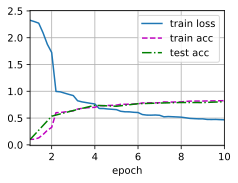

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 卷积神经网络（CNN）是一类使用卷积层的网络。
* 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和池化层。
* 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
* 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
* LeNet是最早发布的卷积神经网络之一。

## 练习

1. 将平均池化层替换为最大池化层，会发生什么？
1. 尝试构建一个基于 LeNet 的更复杂的网络，以提高其准确性。
    1. 调整卷积窗口大小。
    1. 调整输出通道的数量。
    1. 调整激活函数（如 ReLU）。
    1. 调整卷积层的数量。
    1. 调整全连接层的数量。
    1. 调整学习率和其他训练细节（例如，初始化和周期数）。
1. 在 MNIST 数据集上尝试以上改进的网络。
1. 显示不同输入（例如毛衣和外套）时，LeNet 第一层和第二层的激活值。
